In [1]:
import numpy as np
from numpy.linalg import eig
import ot
from scipy.integrate import odeint
from ot.plot import plot2D_samples_mat
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, dia_matrix
from scipy.sparse.linalg import eigs, svds
from scipy.spatial import cKDTree

from lib.SinkhornNP import SolveOT
from lib.get_density import *

In [2]:
def getFurthestPointSubsample(X, k, fp="first", mu=None, D = None):
    """
    A Naive O(N*k) algorithm to do k-furthest points sampling

    Parameters
    ----------
    shape : ndarray (N)
        A set of N points
    Return
    ------
    list
        (subsampled points (min(N,k)-length array of points),
    """
    
    N = len(X)
    if N <= k:
        if mu is None:
            return X,ot.unif(N)
        else:
            return X,mu

    #create output array
    Y = []

    #By default, takes the first point in the list to be the first point
    if fp == "first":
        fp = 0
    elif fp == "random":
        fp = np.random.randint(0,N)
    if D is not None:
        ds = D[fp]
    else:
        ds = np.linalg.norm(X[fp]-X,axis=1)
    Y.append(X[fp])
    indices = [fp]
    
    ind_rest = np.arange(N)
    while len(Y) < k:
        idx = np.argmax(ds)
        s = X[idx]
        if idx in ind_rest:
            indices.append(idx)
            Y.append(s)
        if D is not None:
            ds = np.minimum(ds,D[idx])
        else:
            ds = np.minimum(ds,np.linalg.norm(s-X,axis=1))

    #Compute new (weighted) distribution on this subsampled set via voronoi cells
    voronoi_kdtree = cKDTree(Y)
    test_point_regions = voronoi_kdtree.query(X)[1]
    counts = np.unique(test_point_regions, return_counts=True)[1]
    if mu is None:
        distribution_Y = [counts[i]/N for i in range(k)]
    else:
        distribution_Y = [np.sum(mu[np.where(test_point_regions == l)]) for l in range(k)]
    return np.array(Y), np.array(distribution_Y)#,indices,test_point_regions

In [3]:
def coh_proc(transport,n_vecs,maxiter=None):
    n_x_low,n_y_low = np.shape(transport)
    mu_smoothed = np.array(transport.sum(axis=1)).flatten()
    nu_smoothed = np.array(transport.sum(axis=0)).flatten()

    mu_inv_diag = dia_matrix(((1.0 / mu_smoothed).reshape(1, -1), [0]), shape=(mu_smoothed.shape[0], mu_smoothed.shape[0]))
    nu_inv_diag = dia_matrix(((1.0 / nu_smoothed).reshape(1, -1), [0]), shape=(nu_smoothed.shape[0], nu_smoothed.shape[0]))
    mu_inv_sqrt_diag = dia_matrix((1.0 / np.sqrt(mu_smoothed).reshape(1, -1), [0]), shape=(mu_smoothed.shape[0], mu_smoothed.shape[0]))
    nu_inv_sqrt_diag = dia_matrix((1.0 / np.sqrt(nu_smoothed).reshape(1, -1), [0]), shape=(nu_smoothed.shape[0], nu_smoothed.shape[0]))

    u, s, vt = svds(nu_inv_sqrt_diag.dot(mu_inv_sqrt_diag.dot(transport).T).T, k=n_vecs, which='LM',maxiter=maxiter,random_state=0)
    
    # largest singular values first
    s = s[::-1]
    u = u[:, ::-1]
    vt = vt[::-1, :]

    left_vecs = np.zeros((n_vecs, n_x_low, n_y_low))
    right_vecs = np.zeros((n_vecs, n_x_low, n_y_low))
    left_vecs = mu_inv_sqrt_diag.dot(u).T.real
    right_vecs = nu_inv_sqrt_diag.dot(vt.T).T.real
    
    return s,left_vecs,right_vecs

In [4]:
def cost_eucl(X,Y):
    C = ot.dist(X,Y,metric="euclidean")
    return C

In [5]:
A = 0.25
alpha = 0.25
omega = 2*np.pi

def f(t,x):
    return alpha *np.sin(omega * t) * x**2 + (1 - 2*alpha * np.sin(omega * t)) * x

def dfdx(t,x):
    return 2* alpha *np.sin(omega * t) * x + (1 - 2*alpha * np.sin(omega * t))

def dxdt(t,y):
    outx1 = -np.pi * A * np.sin(np.pi * f(t,y[0])) * np.cos(np.pi * y[1])
    outx2 = np.pi * A * np.cos(np.pi * f(t,y[0])) * np.sin(np.pi * y[1]) * dfdx(t,y[0])
    return np.array([outx1,outx2])


In [6]:
def TStoGyre(X,t_init,t_step):
    return [odeint(dxdt,y0=x, t= [t_init,t_init + t_step],tfirst=True)[1] for x in X]

def generateForGyre(nMeas,m,t_init,t_step):
    Xs = np.array([np.random.rand(m,2) * np.array([2,1]) for _ in range(nMeas)])
    #Xs = Xs_init#np.zeros_like(Xs_init)
    Ys = np.zeros_like(Xs)
    #mus = np.zeros((nMeas,m))
    #nus = np.zeros((nMeas,m))
    for i in range(nMeas):
        #mus[i,:] = np.ones(m)/m
        #nus[i,:] = np.ones(m)/m
        #Xs[i,:] = TStoGyre(Xs_init[i],step=step_large)
        Ys[i,:] = TStoGyre(Xs[i],t_init=t_init,t_step=t_step)

    X = np.concatenate(Xs,axis=0)
    Y = np.concatenate(Ys,axis=0)
    
    return X,Y#X,Xs,Y,Ys,np.array(mus),np.array(nus)

In [7]:
#visualize the vector field

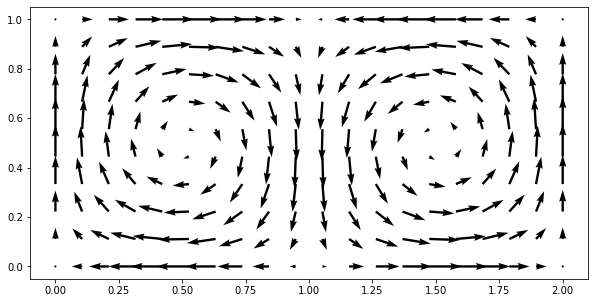

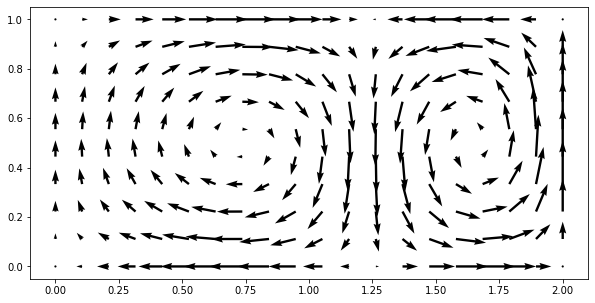

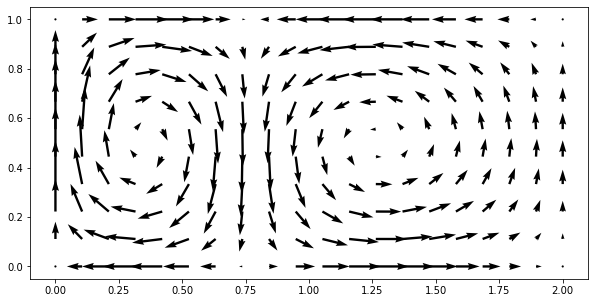

In [8]:
#gridpoints
x,y = np.meshgrid(np.linspace(0,2,20),np.linspace(0,1,10))
gp = np.dstack([x.ravel(), y.ravel()])[0]

t_inits = [0,0.25,0.75]
t_step = 0.01
for t_init in t_inits:
    #forward evolution
    forward_gp = np.array(TStoGyre(gp,t_init=t_init,t_step=t_step))#np.array([TStoGyre(p,step=0.1) for p in gp])

    #plot
    plt.figure(figsize=(10,5))
    plt.quiver(gp[:,0],gp[:,1],forward_gp[:,0] - gp[:,0],forward_gp[:,1] - gp[:,1])
    plt.show()

In [9]:
np.random.seed(1)
m = 50
nMeas = 300
ve = 0.022
gyre_step = 3

In [10]:
#generate supports
x,y = generateForGyre(nMeas,m,t_init = 0,t_step=gyre_step)

#set measures
mu = np.ones(m * nMeas)/(m * nMeas)
nu = np.ones(m * nMeas)/(m * nMeas)

#subsample
S = 1000
sx,mus = getFurthestPointSubsample(x,S,mu=mu,fp="first")
sy,nus = getFurthestPointSubsample(y,S,mu=nu,fp="first")

In [11]:
#Kernels
Res_X = SolveOT(np.ones(m * nMeas)/(m * nMeas),mus,cost_eucl(x,sx),1e-9,ve,1,returnSolver = True)
EK_x = Res_X[1].toarray() #Transport plan from mu to subsampled x points
Res_Y = SolveOT(np.ones(m * nMeas)/(m * nMeas),nus,cost_eucl(y,sy),1e-9,ve,1,returnSolver = True)
EK_y = Res_Y[1].toarray() #Transport plan from nu to subsampled y points

In [12]:
#EMML minimisation
EMML_itr = 5000  #Maxitr for minimisation algo (make it large when M is large)
rho = EMML(EK_x,EK_y,x,m,EMML_itr)

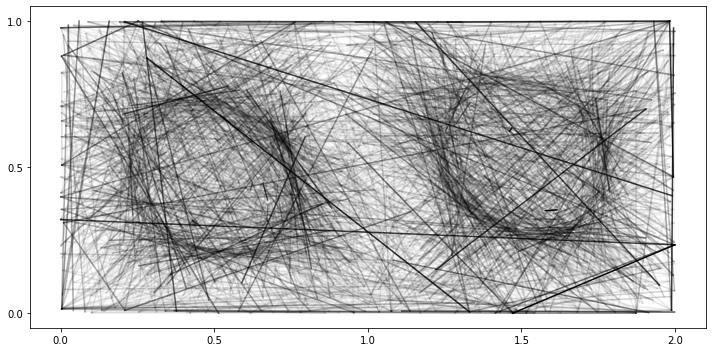

In [13]:
plt.figure(figsize=(10,5))
plot2D_samples_mat(sx,sy,rho.T)
plt.xticks([0,0.5,1,1.5,2])
plt.yticks([0,0.5,1])

plt.tight_layout()
#plt.savefig("./sanity_checks_double_gyre/rho_eps={0}_DeltaT={1}_N={2}_m={3}.png".format(eps,gyre_step,nMeas,m))
plt.show()

In [14]:
q = EK_x.dot(rho.T).dot(EK_y.T) 
#pi = q * ((np.ones(m * nMeas)/(m * nMeas))[:,None] * (np.ones(m * nMeas)/(m * nMeas))[None,:])
pi = q * S**2

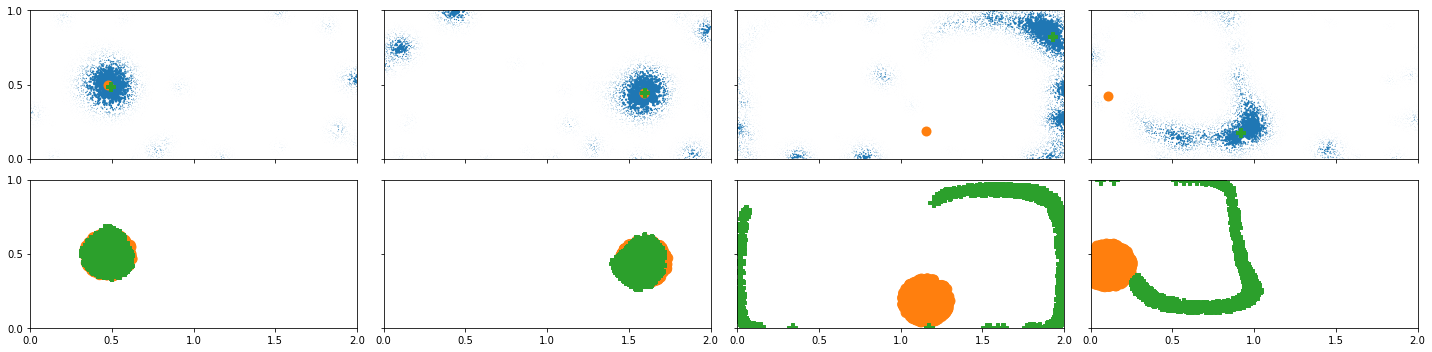

In [15]:
is_in = [80,178]#,355,193]#,166] #inner particles
is_out = [121,123]#,124,125]#,130] #outer particles
blurr_scale = np.sqrt(ve)
size = 100

fig, ax = plt.subplots(2,4,figsize=(20,5),sharex=True,sharey=True)
for a in ax.ravel():
    a.set_xlim([0,2])
    a.set_ylim([0,1])
    a.set_xticks([0,0.5,1,1.5,2])
    a.set_yticks([0,0.5,1])
for i in range(2):
    i_in = is_in[i]
    tmp = np.copy(pi[i_in])
    #tmp[tmp < 1e-10] = 0
    ax[0,i].scatter(y[:,0],y[:,1],s=size * tmp/np.max(tmp),linewidths=0)
    ax[0,i].scatter(x[i_in][0],x[i_in][1], s = size,linewidths=0)
    target_i_in = TStoGyre([x[i_in]],t_init=0,t_step=gyre_step)[0]
    ax[0,i].scatter(target_i_in[0],target_i_in[1],s=size,linewidths=0,c="tab:green",marker="P")

    disc_idxs = np.linalg.norm(x[i_in] - x,axis=1) <= blurr_scale
    U_X = x[disc_idxs]
    U_Y = np.array([TStoGyre([x],t_init=0,t_step=gyre_step)[0] for x in U_X])
    ax[1,i].scatter(U_X[:,0],U_X[:,1], s = size * mu[disc_idxs]/np.max(mu[disc_idxs]),c="tab:orange",marker="o")
    ax[1,i].scatter(U_Y[:,0],U_Y[:,1], s = size * mu[disc_idxs]/np.max(mu[disc_idxs]),c="tab:green",marker="P")

    
    i_out = is_out[i]
    tmp = np.copy(pi[i_out])
    #tmp[tmp < 1e-10] = 0
    ax[0,2+i].scatter(y[:,0],y[:,1],s=size * tmp/np.max(tmp),linewidths=0)
    ax[0,2+i].scatter(x[i_out][0],x[i_out][1], s = size,linewidths=0)
    target_i_out = TStoGyre([x[i_out]],t_init=0,t_step=gyre_step)[0]
    ax[0,2+i].scatter(target_i_out[0],target_i_out[1],s=size,linewidths=0,c="tab:green",marker="P")
    
    disc_idxs = np.linalg.norm(x[i_out] - x,axis=1) <= blurr_scale
    U_X = x[disc_idxs]
    U_Y = np.array([TStoGyre([x],t_init=0,t_step=gyre_step)[0] for x in U_X])
    ax[1,2+i].scatter(U_X[:,0],U_X[:,1], s = size * mu[disc_idxs]/np.max(mu[disc_idxs]),c="tab:orange",marker="o")
    ax[1,2+i].scatter(U_Y[:,0],U_Y[:,1], s = size * mu[disc_idxs]/np.max(mu[disc_idxs]),c="tab:green",marker="P")


plt.tight_layout()
#plt.savefig("./sanity_checks_double_gyre/slices_eps={0}_DeltaT={1}_N={2}_m={3}.png".format(eps,gyre_step,nMeas,m))
plt.show()

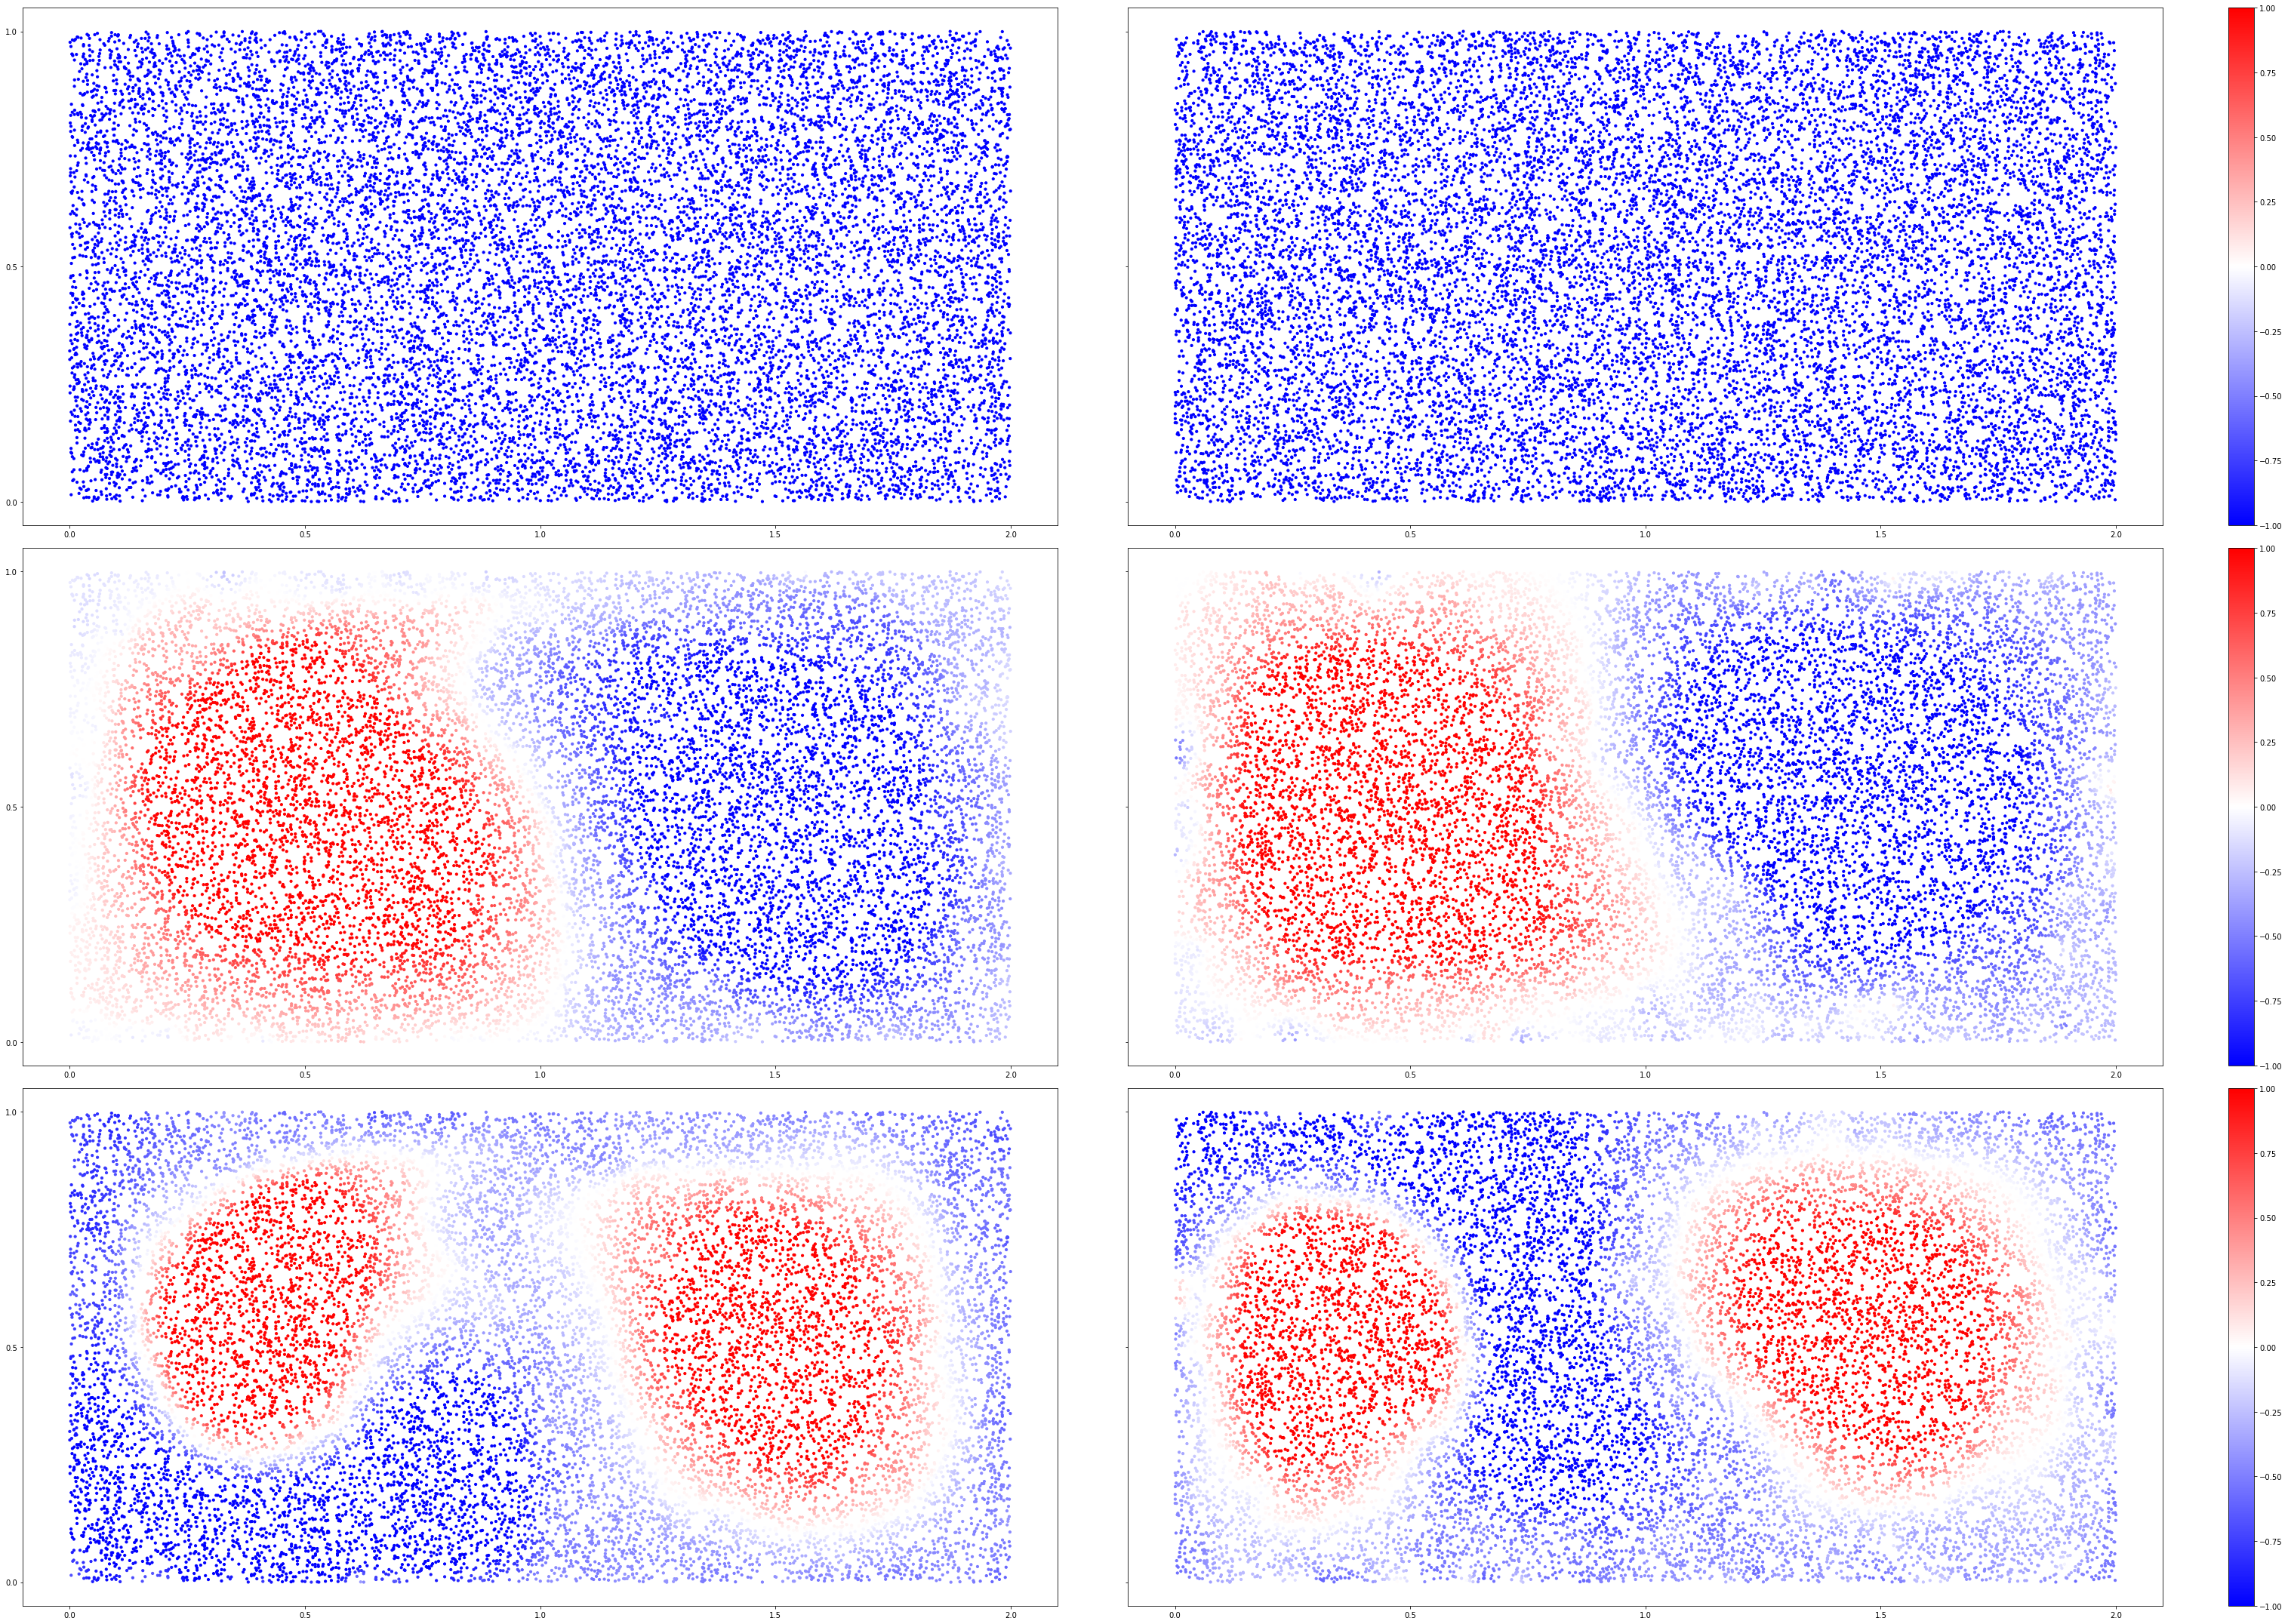

In [16]:
vals, left, right = coh_proc(pi,3)

cmap = "bwr"
i=0
fig, ax = plt.subplots(3,2,figsize=(20*2+7,30),sharey=True)
size = 10
scale = 1
for a in ax.ravel():
    a.set_xticks([0,0.5,1.0,1.5,2])
    a.set_yticks([0,0.5,1])
    a.set(aspect=1)
    
for vecl,vecr in zip(left,right):
    ax[i,0].scatter(x[:,0],x[:,1],c=vecl,s=size,cmap = cmap,vmin=-1,vmax=1)
    last_ax = ax[i,1].scatter(y[:,0],y[:,1],c=vecr,s=size,cmap = cmap,vmin=-1,vmax=1)
    plt.colorbar(last_ax)
    i+= 1
plt.tight_layout()
#plt.savefig("./sanity_checks_double_gyre/eigs_eps={0}_DeltaT={1}_N={2}_m={3}.png".format(eps,gyre_step,nMeas,m))
plt.show()

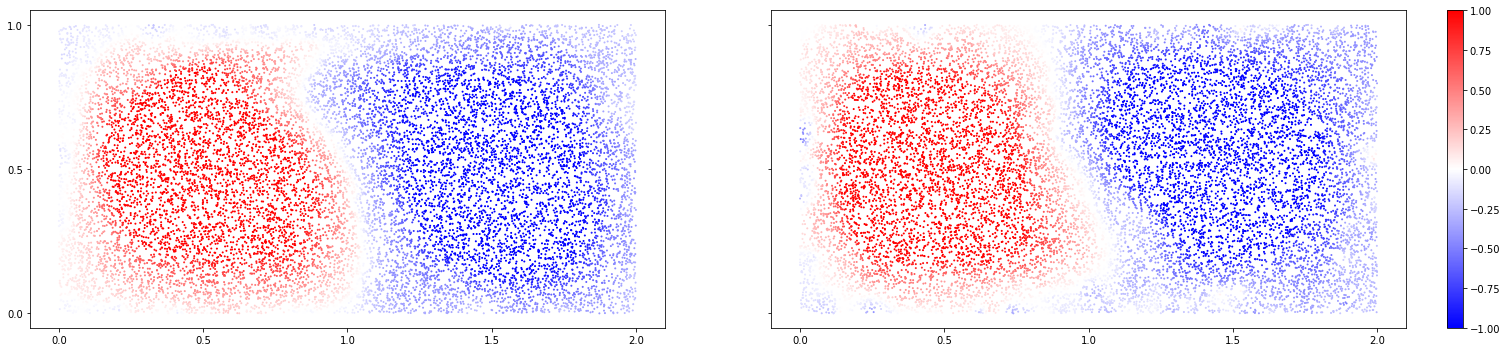

In [17]:
cmap = "bwr"
scale = 1
size = 1
fig, ax = plt.subplots(1,2,figsize=(23,5),sharey=True)
for a in ax.ravel():
    a.set_xticks([0,0.5,1.0,1.5,2])
    a.set_yticks([0,0.5,1])
    a.set(aspect=1)
i = 0
vecl = left[i+1]
vecr = right[i+1]
ax[0].scatter(x[:,0],x[:,1],c=vecl,s=size,cmap = cmap,vmin=-1,vmax=1)
last_ax = ax[1].scatter(y[:,0],y[:,1],c=vecr,s=size,cmap = cmap,vmin=-1,vmax=1)
plt.colorbar(last_ax)
plt.tight_layout()
plt.show()

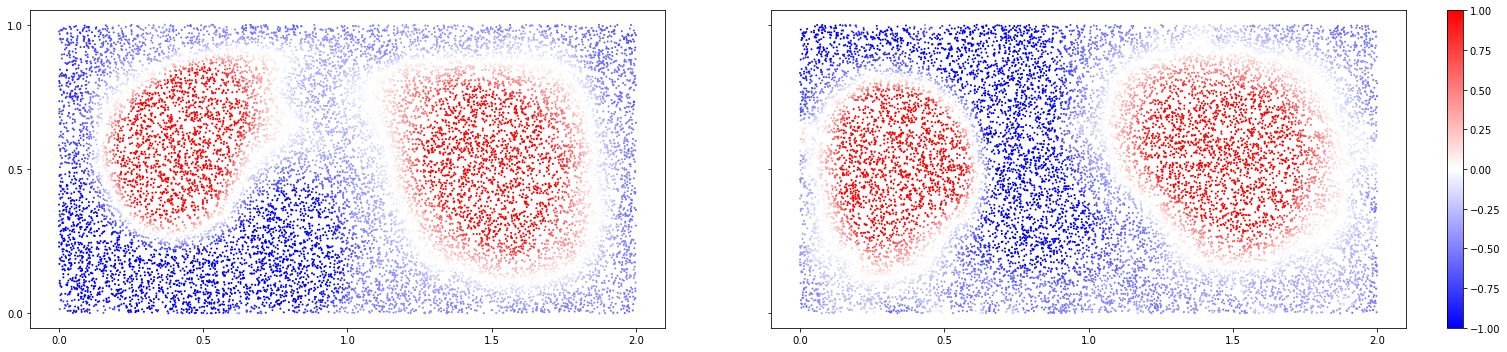

In [18]:
cmap = "bwr"
scale = 1
size = 1
fig, ax = plt.subplots(1,2,figsize=(23,5),sharey=True)
for a in ax.ravel():
    a.set_xticks([0,0.5,1.0,1.5,2])
    a.set_yticks([0,0.5,1])
    a.set(aspect=1)
i = 1
vecl = left[i+1]
vecr = right[i+1]
ax[0].scatter(x[:,0],x[:,1],c=vecl,s=size,cmap = cmap,vmin = -1, vmax = 1)
last_ax = ax[1].scatter(y[:,0],y[:,1],c=vecr,s=size,cmap = cmap,vmin = -1, vmax = 1)
plt.colorbar(last_ax)
plt.tight_layout()
plt.show()